DS 8014 Graph Mining
Assignment 5

Gorkem Sarp;
Richa Sharma

Que 5:

Some of the code was taken from our labs

In [1]:
#! pip install python-igraph
#! pip install plfit
#! pip install partition-igraph
#!pip3 install -U pip
#!pip3 install -U setuptools
#!pip3 install --no-cache-dir cairocffi
#!pip install umap-learn

In [2]:
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from collections import Counter
import os
import umap
import pickle
import partition_igraph
import subprocess
from sklearn.metrics import adjusted_mutual_info_score as AMI

## we used those for the book, but you can change to other colors
cls_edges = 'gainsboro'
cls = ['silver','dimgray','black']

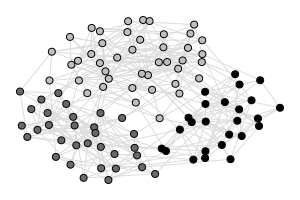

In [3]:
## read graph and communities
z = ig.Graph.Read_Ncol('ABCDdata/abcd_100.dat',directed=False)
c = np.loadtxt('ABCDdata/abcd_100_comms.dat',dtype='uint16',usecols=(1))
z.vs['comm'] = [c[int(x['name'])-1]-1 for x in z.vs]
gt = {k:(v-1) for k,v in enumerate(z.vs['comm'])}
## map between int(name) to key
n2k = {int(v):k for k,v in enumerate(z.vs['name'])}
z.vs['size'] = 7
z.es['color'] = cls_edges
z.vs['color'] = [cls[i] for i in z.vs['comm']]
ig.plot(z, bbox=(0,0,300,200))

In [4]:
#z.vs['comm']

In [5]:
## internal degrees
in_deg_0 = z.subgraph_edges([e for e in z.es if z.vs['comm'][e.tuple[0]]==0 and z.vs['comm'][e.tuple[1]]==0],
                            delete_vertices=False).degree()
in_deg_1 = z.subgraph_edges([e for e in z.es if z.vs['comm'][e.tuple[0]]==1 and z.vs['comm'][e.tuple[1]]==1],
                            delete_vertices=False).degree()
in_deg_2 = z.subgraph_edges([e for e in z.es if z.vs['comm'][e.tuple[0]]==2 and z.vs['comm'][e.tuple[1]]==2],
                            delete_vertices=False).degree()

## compute z (normalized within-module degree)
z.vs['in_deg'] = [in_deg_0[i] + in_deg_1[i] + in_deg_2[i] for i in range(z.vcount())]
mu = [np.mean([x for x in in_deg_0 if x>0]),np.mean([x for x in in_deg_1 if x>0]),np.mean([x for x in in_deg_2 if x>0])]
sig = [np.std([x for x in in_deg_0 if x>0],ddof=1),np.std([x for x in in_deg_1 if x>0],ddof=1),np.std([x for x in in_deg_2 if x>0],ddof=1)]
z.vs['z'] = [(v['in_deg']-mu[v['comm']])/sig[v['comm']] for v in z.vs]

## computing p (participation coefficient)
z.vs['deg'] = z.degree()
z.vs['out_deg'] = [v['deg'] - v['in_deg'] for v in z.vs]
z.vs['p'] = [1-(v['in_deg']/v['deg'])**2-(v['out_deg']/v['deg'])**2 for v in z.vs]
D = pd.DataFrame(np.array([z.vs['z'],z.vs['p']]).transpose(),columns=['z','p']).sort_values(by='z',ascending=False)
D.head(8)

,z,p
5,2.558409,0.244898
24,2.380025,0.260355
2,2.367309,0.277778
31,2.367309,0.165289
22,1.890355,0.355030
37,1.890355,0.000000
48,1.890355,0.165289
32,1.818368,0.180000


In [6]:
hubs = 0
provincial_hubs = 0
connector_hubs = 0
kinless_hubs = 0
non_hub = 0
ultra_peripheral_nodes = 0
peripheral_nodes = 0
connector_nodes = 0
kinless_nodes = 0 

for v in z.vs:
    if v['z'] > 2.5: #hub
        hubs += 1
        
        if v['p'] < 0.3: #provincial hubs
            provincial_hubs += 1
            
        if v['p'] >= 0.3 and v['p'] < 0.75: #connector hubs
            connector_hubs += 1
            
        if v['p'] >= 0.75: #kinless hubs
            kinless_hubs += 1
    
    if v['z'] <= 2.5: ## non-hub
        non_hub += 1
        
        if v['p'] < 0.05: #ultra-peripheral nodes
            ultra_peripheral_nodes += 1
                
        if v['p'] >= 0.05 and v['p'] < 0.62:  #peripheral nodes
            peripheral_nodes += 1
        
        if v['p'] >= 0.62 and v['p'] < 0.8:  #connector nodes
            connector_nodes += 1
        
        if v['p'] >= 0.8: #kinless nodes
            kinless_nodes += 1



In [7]:
print("total nodes", z.vcount())
print("----------")
print("hubs", hubs)
print("provincial hubs", provincial_hubs)
print("connector hubs ", connector_hubs )
print("kinless hubs", kinless_hubs )
print("----------")
print("non hub ", non_hub )   
print("ultra peripheral nodes ", ultra_peripheral_nodes )    
print("peripheral nodes ", peripheral_nodes )   
print("connector nodes ", connector_nodes)
print("kinless nodes", kinless_nodes)    

total nodes 100
----------
hubs 1
provincial hubs 1
connector hubs  0
kinless hubs 0
----------
non hub  99
ultra peripheral nodes  18
peripheral nodes  81
connector nodes  0
kinless nodes 0


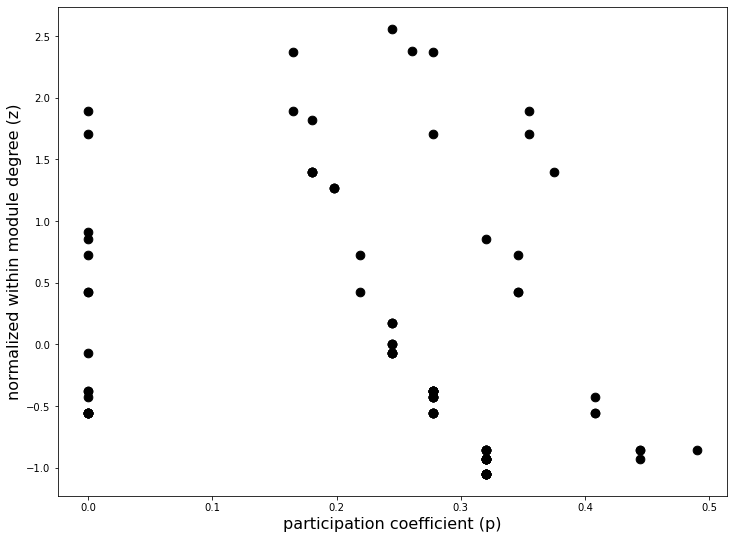

In [10]:
fig, ax = plt.subplots(figsize=(12,9))
ax.scatter(z.vs['p'],z.vs['z'],marker='o',s=75, color='k')

plt.xlabel('participation coefficient (p)',fontsize=16)
plt.ylabel('normalized within module degree (z)',fontsize=16);

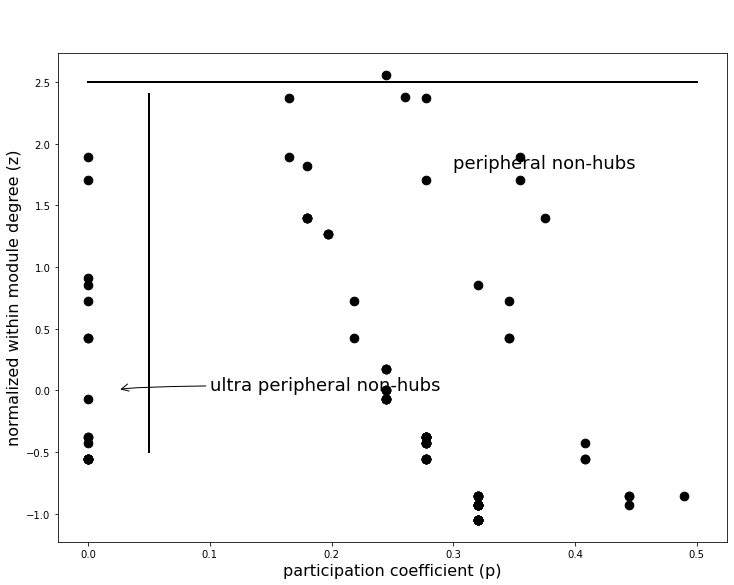

In [9]:
## Figure 5.3(b) -- comparing the roles
fig, ax = plt.subplots(figsize=(12,9))
ax.scatter(z.vs['p'],z.vs['z'],marker='o',s=75, color='k')

plt.plot([0, .5], [2.5, 2.5], color='k', linestyle='-', linewidth=2)
plt.plot([.05, .05], [-.5, 2.4], color='k', linestyle='-', linewidth=2)

ax.annotate('provincial hubs',(.3,3), fontsize=18)
ax.annotate('peripheral non-hubs',(.3,1.8), fontsize=18)
ax.annotate('ultra peripheral non-hubs',(0.025,0.0),xytext=(.1,0), fontsize=18,
             arrowprops = dict( arrowstyle="->", connectionstyle="angle3,angleA=0,angleB=-90"))

plt.xlabel('participation coefficient (p)',fontsize=16)
plt.ylabel('normalized within module degree (z)',fontsize=16);
#plt.savefig('zachary_roles_2.eps')